In [1]:
import numpy as np
import matplotlib.pyplot as plt

class MultilayerPerceptron:
    def __init__(self, input_size, hidden_layer_sizes, output_size, activation_functions_type):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.af_type = activation_functions_type
        self.layers = len(hidden_layer_sizes) + 1 

        self.weights = [np.random.random((input_size, hidden_layer_sizes[0]))]
        self.biases = [np.random.random((1, hidden_layer_sizes[0]))]

        for i in range(1, self.layers-1):
            self.weights.append(np.random.random((hidden_layer_sizes[i - 1], hidden_layer_sizes[i])))
            self.biases.append(np.random.random((1, hidden_layer_sizes[i])))
        self.weights.append(np.random.random((hidden_layer_sizes[self.layers-2], output_size)))
        self.biases.append(np.random.random((1, output_size)))
    
    def activation_function(self, x, type='sigmoid'):
        if type == 'sigmoid':
            return 2 / (1 + np.exp(-x)) - 1
        elif type == 'linear':
            return x
        elif type == 'ReLU':
            return np.maximum(0, x)  # ReLU activation function
        elif type == 'tanh':
            return np.tanh(x)
    def activation_function_derivative(self, x, type='sigmoid'):
        if type == 'sigmoid':
            return (1 - self.activation_function(x, type='sigmoid') ** 2) / 2
        elif type == 'linear':
            return 1
        elif type == 'ReLU':
            return np.where(x <= 0, 0, 1)  # Derivative of ReLU
        elif type == 'tanh':
            return 1-np.tanh(x)**2

    def forward(self, x):
        layer_output = x

        for i in range(self.layers):
            layer_input = layer_output @ self.weights[i] + self.biases[i]
            layer_output = self.activation_function(layer_input, self.af_type[i])

        return layer_output

    def gradient_calculation(self, x, grad):
        layer_outputs = [x]
        layer_inputs = []

        # Forward pass
        for i in range(self.layers):
            layer_input = layer_outputs[i] @ self.weights[i] + self.biases[i]
            layer_inputs.append(layer_input)
            layer_output = self.activation_function(layer_input, self.af_type[i])
            layer_outputs.append(layer_output)

        # Backpropagation
        error = grad#(e @ np.linalg.pinv(Ac) @ np.ones([2,1]))#y - layer_outputs[-1]
        delta = error * self.activation_function_derivative(layer_inputs[-1], self.af_type[-1])
        grads = [{'weights': 0, 'bias': 0} for _ in range(self.layers)]

        for i in range(self.layers - 1, -1, -1):
            grads[i]['weights'] = np.sum(np.expand_dims(delta, 1) * np.expand_dims(layer_outputs[i], 2), 0)
            grads[i]['bias'] = np.sum(delta, axis=0, keepdims=True)
            if i > 0:
                # print(delta.shape, self.weights[i].shape)
                error = delta @ self.weights[i].T
                delta = error * self.activation_function_derivative(layer_inputs[i - 1], self.af_type[i - 1])
        return grads, delta

    def train(self, x, grad, update_step_num=10, learning_rate=0.001):
        for i in range(update_step_num):
            grads, _ = self.gradient_calculation(x, grad)

            for j in range(self.layers):
                self.weights[j] += learning_rate * grads[j]['weights']#np.clip(grads[j]['weights'],-1,1)
                self.biases[j] += learning_rate * grads[j]['bias']#np.clip(grads[j]['bias'],-1,1)


In [2]:
# System parameters 
M = 1 #kg
g = 9.81 
L = 1 #m
I = 0.5
J_sys = 0.008
k = 0.3

In [3]:
# Define system ODE: dx/dt = f(x,u)
#x = [q1, q2, q1_dot, q2_dot]
import numpy as np
from scipy.integrate import odeint

def sys_ode(x,u):
    x=x.T
    dx_1 = x[0][2] 
    dx_2 = x[0][3]
    dx_3 = -M*g*L*np.sin(x[0][0])/I - k/I * (x[0][0]-x[0][1])
    dx_4 = -k/J_sys * (x[0][1]-x[0][0]) + 1/J_sys * u 
    dx = np.array([dx_1, dx_2, dx_3, dx_4]).reshape([1,-1])
    
    return dx

In [4]:
class Single_Link_Flexible_Joint:
    def __init__(self, dt = 0.001):
        self.Ac = -20*np.eye(4)
        self.dt = dt
        self.t = np.linspace(0, 10, int((10-0)/dt))
        self.xd = np.array([[.2*np.sin(4*np.pi*self.t/3), np.sin(4*np.pi*(self.t)/3), np.sin(4*np.pi*self.t/3), 2*np.cos(4*np.pi*(self.t)/3)]]).T
        self.C = np.array([[0, 1, 0, 0]])
        self.yd = self.C@ self.xd
        self.x = np.array([[.1, .2, .3, .4]]).T
        self.y = self.C@self.x
        self.T_A = .3*np.array([(np.sign(self.t-5) - np.sign(self.t-7)),(np.sign(self.t-5) - np.sign(self.t-7))*(-2), (np.sign(self.t-5) - np.sign(self.t-7))*(-5), (np.sign(self.t-5) - np.sign(self.t-7))*(-3)])
        self.T_S = np.array([np.sign(self.t-2) - np.sign(self.t-5)])
    def step(self, u, fault = [False, 0]):
        self.x_dot = sys_ode(self.x, u)
        self.x += self.x_dot.T * self.dt
        #self.y = self.x#[:,0].reshape([1,-1])
        if fault[0]:
            self.x += self.T_A[:,fault[1]].reshape([-1,1]) * self.dt
            self.y = self.C@self.x + self.T_S[:,fault[1]].reshape([-1,1])
    def J(self, x = np.zeros([4,1])):
        J = np.array([[0,0,1,0],[0,0,0,1],[-M*g*L*np.cos(x[0][0])-k/I,k/I,0,0],[k/J_sys,-k/I,0,0]])
        return J

In [12]:
controller = MultilayerPerceptron(input_size = 8, hidden_layer_sizes = [4,4], output_size = 1, activation_functions_type = ['tanh', 'tanh','linear'])
identifier = MultilayerPerceptron(input_size = 4+1+4, hidden_layer_sizes = [4], output_size = 4, activation_functions_type = ['sigmoid', 'linear'])
T_A_model = MultilayerPerceptron(input_size = 4+1, hidden_layer_sizes = [8, 4], output_size = 4, activation_functions_type = ['sigmoid', 'sigmoid', 'linear'])
T_S_model = MultilayerPerceptron(input_size = 4+1, hidden_layer_sizes = [2], output_size = 1, activation_functions_type = ['sigmoid', 'linear'])
plant = Single_Link_Flexible_Joint()
# plant.yd = np.copy(history['y'])
# plant2 = Pendulum_Nonlinear_System()
# u = np.sin(np.linspace(0,10,len(plant.t)))
# plant.T_A *= 0
# plant.T_S *= 0
T_A_hat_new = np.zeros([1,4])
history = {'x': np.zeros(plant.xd.shape), 'xhat': np.zeros(plant.xd.shape), 'u':[], 'T_A':np.zeros(plant.T_A.shape), 'T_S':np.zeros(plant.T_S.shape), 'y':[], 'y2':[], 'y_hat':[]}
for i in range(len(plant.t)):
    xc = np.concatenate((np.copy(plant.x), plant.xd[i])).T

    state_old = np.copy(plant.x)
    u = controller.forward(xc)
    # u[0,0] = np.sin(plant.t[i])
    iden_input = np.concatenate((state_old.T, u, T_A_hat_new),-1)
    state_hat = identifier.forward(iden_input)
    
    
    fault_input = np.concatenate((state_hat, np.array(u[0,0]).reshape([1,-1])),-1)
    T_A_hat_new = T_A_model.forward(fault_input)
    T_S_hat_new = T_S_model.forward(fault_input)

    y_hat_new = (plant.C@state_hat.T).T + T_S_hat_new

    plant.step(u[0,0], fault = [True, i])
    e_y = np.copy(plant.y) - y_hat_new
    # plant2.step(u[i], fault = [False, i])
    history['x'][i] = plant.x
    history['xhat'][i] = state_hat.T
    history['u'].append(u[0,0])
    history['T_A'][:,i] = T_A_hat_new[0]
    history['T_S'][:,i] = T_S_hat_new[0]
    history['y'].append(plant.y[0,0])
    history['y_hat'].append(y_hat_new[0,0])

    e_x = np.copy(plant.x) - state_hat.T
    identifier.train(iden_input, e_x.T, update_step_num = 1, learning_rate=0.1)

    grad_T_S = e_y.T
    T_S_model.train(fault_input, grad_T_S.T, update_step_num = 1, learning_rate=0.05)

    e_y = np.copy(plant.y) - y_hat_new #- T_S_hat_new
    e_x = state_hat.T - np.copy(plant.xd[i])
    grad_T_A = e_y@plant.C.reshape([1,-1])@np.linalg.pinv(plant.J())#-e_x.T#(e_x.T@np.linalg.pinv(plant.Ac))#@plant.C.reshape([1,-1])@np.linalg.pinv(plant.Ac)#e_y.T@plant.C.reshape([1,-1])@np.linalg.pinv(plant.Ac)#np.linalg.pinv(plant.J())
    T_A_model.train(fault_input, grad_T_A.reshape([1,-1]), update_step_num = 1, learning_rate=.05)

    e_x = state_hat.T - np.copy(plant.xd[i])
    print()
    grad_controller = (e_x.T @ np.linalg.pinv(plant.Ac) @ np.ones([4,1])) - .01*u
    controller.train(xc, grad_controller, update_step_num = 1, learning_rate=1)

    


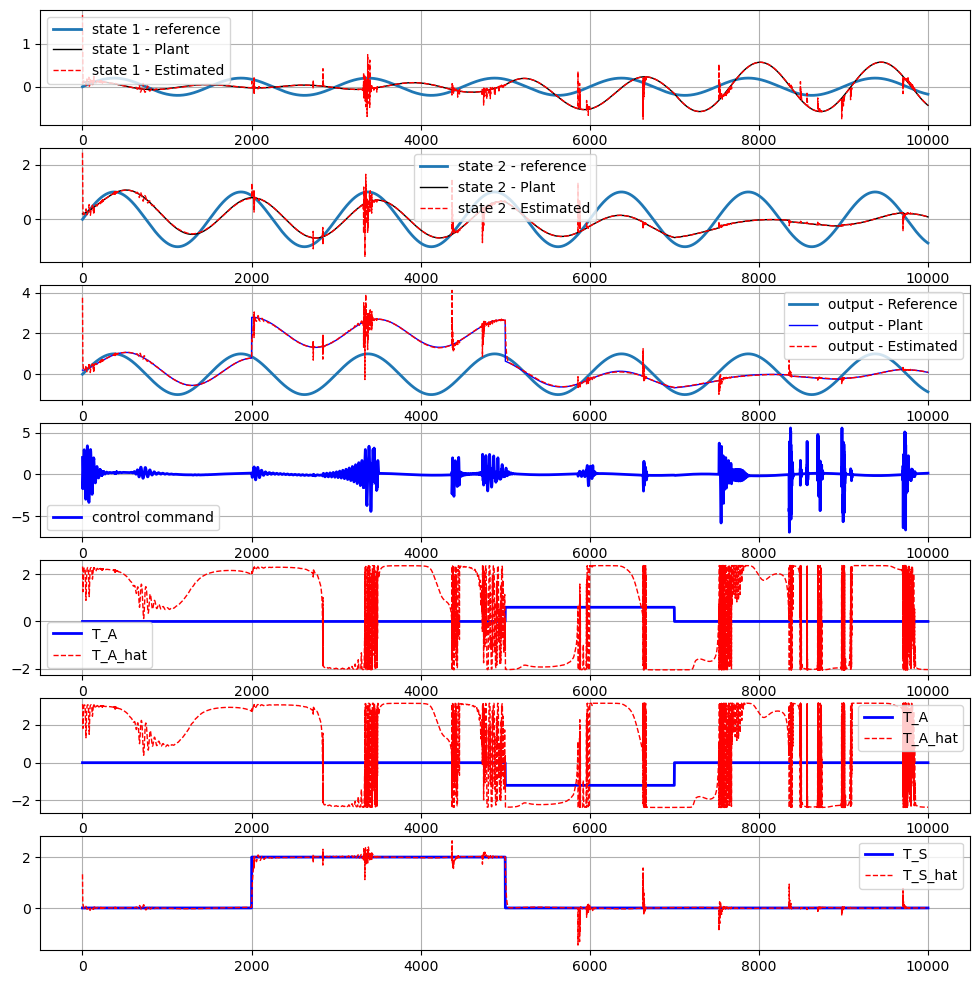

In [14]:
plt.figure(figsize=(12, 14))
plt.subplot(8,1,1)
plt.plot(plant.xd[:,0,0], '-', label='state 1 - reference', linewidth = 2)
plt.plot(history['x'][:,0,0], 'k-', label='state 1 - Plant', linewidth = 1)
plt.plot(history['xhat'][:,0,0], 'r--', label='state 1 - Estimated', linewidth = 1)
plt.grid('on')
plt.legend()
plt.subplot(8,1,2)
plt.plot(plant.xd[:,1,0], '-', label='state 2 - reference', linewidth = 2)
plt.plot(history['x'][:,1,0], 'k-', label='state 2 - Plant', linewidth = 1)
plt.plot(history['xhat'][:,1,0], 'r--', label='state 2 - Estimated', linewidth = 1)
plt.grid('on')
plt.legend()

plt.subplot(8,1,3)
plt.plot(plant.yd[:,0,0], '-', label='output - Reference', linewidth = 2)
plt.plot(history['y'], 'b-', label='output - Plant', linewidth = 1)
plt.plot(history['y_hat'], 'r--', label='output - Estimated', linewidth = 1)
plt.grid('on')
plt.legend()

plt.subplot(8,1,4)
plt.plot(history['u'], 'b-', label='control command', linewidth = 2)
plt.grid('on')
plt.legend()

plt.subplot(8,1,5)
plt.plot(plant.T_A[0,:], 'b-', label='T_A', linewidth = 2)
plt.plot(history['T_A'][0,:], 'r--', label='T_A_hat', linewidth = 1)
plt.grid('on')
plt.legend()

plt.subplot(8,1,6)
plt.plot(plant.T_A[1,:], 'b-', label='T_A', linewidth = 2)
plt.plot(history['T_A'][1,:], 'r--', label='T_A_hat', linewidth = 1)
plt.grid('on')
plt.legend()

plt.subplot(8,1,7)
plt.plot(plant.T_S[0,:], 'b-', label='T_S', linewidth = 2)
plt.plot(history['T_S'][0,:], 'r--', label='T_S_hat', linewidth = 1)
plt.grid('on')
plt.legend()



In [9]:
Y_new = np.copy(history['y']).reshape([-1,1,1])
X_new = np.copy(history['x'])
u_new = np.copy(history['u']).reshape([-1,1])

In [74]:
# controller = MultilayerPerceptron(input_size = 8, hidden_layer_sizes = [4,4], output_size = 1, activation_functions_type = ['tanh', 'tanh','linear'])
identifier = MultilayerPerceptron(input_size = 4+1+4, hidden_layer_sizes = [17], output_size = 4, activation_functions_type = ['tanh', 'linear'])
T_A_model = MultilayerPerceptron(input_size = 4+1, hidden_layer_sizes = [2], output_size = 4, activation_functions_type = ['tanh', 'linear'])
T_S_model = MultilayerPerceptron(input_size = 4+1, hidden_layer_sizes = [2], output_size = 1, activation_functions_type = ['sigmoid', 'linear'])
plant = Single_Link_Flexible_Joint()
plant.yd = Y_new
plant.xd = X_new
# plant.yd = np.copy(history['y'])
# plant2 = Pendulum_Nonlinear_System()
# u = np.sin(np.linspace(0,10,len(plant.t)))
# plant.T_A *= 0
# plant.T_S *= 0
T_A_hat_new = np.zeros([1,4])
history = {'x': np.zeros(plant.xd.shape), 'xhat': np.zeros(plant.xd.shape), 'u':[], 'T_A':np.zeros(plant.T_A.shape), 'T_S':np.zeros(plant.T_S.shape), 'y':[], 'y2':[], 'y_hat':[]}
for i in range(len(plant.t)):
    xc = np.concatenate((np.copy(plant.x), plant.xd[i])).T

    state_old = np.copy(plant.x)
    # u = controller.forward(xc)
    # u[0,0] = np.sin(plant.t[i])
    u = u_new[i,:].reshape([1,-1])
    iden_input = np.concatenate((state_old.T, u, T_A_hat_new),-1)
    state_hat = identifier.forward(iden_input)
    
    
    fault_input = np.concatenate((state_hat, np.array(u[0,0]).reshape([1,-1])),-1)
    T_A_hat_new = T_A_model.forward(fault_input)
    T_S_hat_new = T_S_model.forward(fault_input)

    y_hat_new = (plant.C@state_hat.T).T + T_S_hat_new

    plant.step(u[0,0], fault = [True, i])
    e_y = np.copy(plant.y) - y_hat_new
    # plant2.step(u[i], fault = [False, i])
    history['x'][i] = plant.x
    history['xhat'][i] = state_hat.T
    history['u'].append(u[0,0])
    history['T_A'][:,i] = T_A_hat_new[0]
    history['T_S'][:,i] = T_S_hat_new[0]
    history['y'].append(plant.y[0,0])
    history['y_hat'].append(y_hat_new[0,0])

    e_x = np.copy(plant.x) - state_hat.T
    identifier.train(iden_input, e_x.T, update_step_num = 1, learning_rate=0.1)

    grad_T_S = e_y.T
    T_S_model.train(fault_input, grad_T_S.T, update_step_num = 1, learning_rate=0.05)

    e_y = np.copy(plant.y) - (plant.C@state_hat.T).T
    e_x = state_hat.T - np.copy(plant.xd[i])
    grad_T_A = e_y@plant.C.reshape([1,-1])@np.linalg.pinv(plant.J())#-e_x.T#(e_x.T@np.linalg.pinv(plant.Ac))#@plant.C.reshape([1,-1])@np.linalg.pinv(plant.Ac)#e_y.T@plant.C.reshape([1,-1])@np.linalg.pinv(plant.Ac)#np.linalg.pinv(plant.J())
    T_A_model.train(fault_input, grad_T_A.reshape([1,-1]), update_step_num = 20, learning_rate=.05)

    # e_x = state_hat.T - np.copy(plant.xd[i])
    # print()
    # grad_controller = (e_x.T @ np.linalg.pinv(plant.Ac) @ np.ones([4,1])) - .01*u
    # controller.train(xc, grad_controller, update_step_num = 1, learning_rate=1)

    


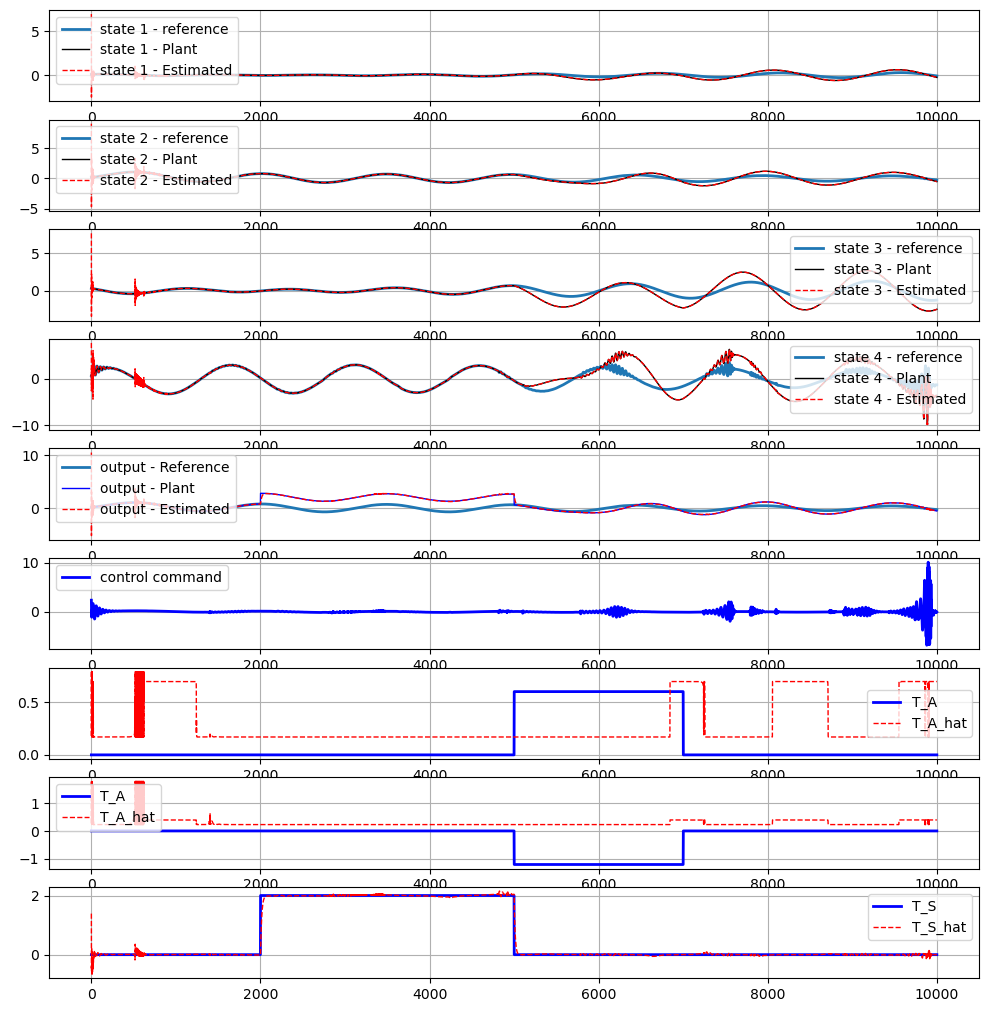

In [75]:
plt.figure(figsize=(12, 14))
plt.subplot(10,1,1)
plt.plot(plant.xd[:,0,0], '-', label='state 1 - reference', linewidth = 2)
plt.plot(history['x'][:,0,0], 'k-', label='state 1 - Plant', linewidth = 1)
plt.plot(history['xhat'][:,0,0], 'r--', label='state 1 - Estimated', linewidth = 1)
plt.grid('on')
plt.legend()
plt.subplot(10,1,2)
plt.plot(plant.xd[:,1,0], '-', label='state 2 - reference', linewidth = 2)
plt.plot(history['x'][:,1,0], 'k-', label='state 2 - Plant', linewidth = 1)
plt.plot(history['xhat'][:,1,0], 'r--', label='state 2 - Estimated', linewidth = 1)
plt.grid('on')
plt.legend()

plt.subplot(10,1,3)
plt.plot(plant.xd[:,2,0], '-', label='state 3 - reference', linewidth = 2)
plt.plot(history['x'][:,2,0], 'k-', label='state 3 - Plant', linewidth = 1)
plt.plot(history['xhat'][:,2,0], 'r--', label='state 3 - Estimated', linewidth = 1)
plt.grid('on')
plt.legend()
plt.subplot(10,1,4)
plt.plot(plant.xd[:,3,0], '-', label='state 4 - reference', linewidth = 2)
plt.plot(history['x'][:,3,0], 'k-', label='state 4 - Plant', linewidth = 1)
plt.plot(history['xhat'][:,3,0], 'r--', label='state 4 - Estimated', linewidth = 1)
plt.grid('on')
plt.legend()

plt.subplot(10,1,5)
plt.plot(plant.yd[:,0,0], '-', label='output - Reference', linewidth = 2)
plt.plot(history['y'], 'b-', label='output - Plant', linewidth = 1)
plt.plot(history['y_hat'], 'r--', label='output - Estimated', linewidth = 1)
plt.grid('on')
plt.legend()

plt.subplot(10,1,6)
plt.plot(history['u'], 'b-', label='control command', linewidth = 2)
plt.grid('on')
plt.legend()

plt.subplot(10,1,7)
plt.plot(plant.T_A[0,:], 'b-', label='T_A', linewidth = 2)
plt.plot(history['T_A'][0,:], 'r--', label='T_A_hat', linewidth = 1)
plt.grid('on')
plt.legend()

plt.subplot(10,1,8)
plt.plot(plant.T_A[1,:], 'b-', label='T_A', linewidth = 2)
plt.plot(history['T_A'][1,:], 'r--', label='T_A_hat', linewidth = 1)
plt.grid('on')
plt.legend()

plt.subplot(10,1,9)
plt.plot(plant.T_S[0,:], 'b-', label='T_S', linewidth = 2)
plt.plot(history['T_S'][0,:], 'r--', label='T_S_hat', linewidth = 1)
plt.grid('on')
plt.legend()

